# Recommender System - RMSE

The recommender here use the RMSE loss function. The adam optimizer is an improved gradient descent method.

## 1. Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline


import scipy
import scipy.io
import scipy.sparse as sp


%load_ext autoreload
%autoreload 2

In [2]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


## 2. Data preprocessing

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from helpers import convert_train

submission,_,_=convert_train(samples)
data, n_users, n_movies = convert_train(ratings)

# take 15 more frequent users
g = data.groupby('user_id')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

# take 15 more frequent movies
g = data.groupby('movie_id')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

# combine frequent users and most rated movies
top_r = data.join(top_users, rsuffix = '_r', how = 'inner', on = 'user_id')
top_r = top_r.join (top_movies, rsuffix = '_r', how = 'inner', on = 'movie_id')

pd.crosstab(top_r.user_id, top_r.movie_id, top_r.rating, aggfunc = np.sum)

movie_id,5,13,45,59,133,155,177,255,470,494,593,595,607,667,977
user_id,,,,,,,,,,,,,,,
965,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,NaN,NaN,5.0,5.0
999,NaN,5.0,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,5.0,NaN,5.0,3.0
1569,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0
1829,5.0,NaN,5.0,5.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,5.0,NaN,NaN
1877,NaN,5.0,5.0,NaN,5.0,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN
2037,5.0,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN
4599,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN,NaN,5.0
5288,5.0,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN,5.0,5.0,NaN
5511,NaN,5.0,5.0,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0


In [12]:
user_enc = LabelEncoder()
data ['user'] = user_enc.fit_transform(data['user_id'].values)
n_users = data ['user'].nunique()

item_enc = LabelEncoder()
data ['movie'] = item_enc.fit_transform(data['movie_id'].values)
n_movies = data ['movie'].nunique()


data ['rating'] = data ['rating'].values.astype(np.int)
min_rating = min(data['rating'])
max_rating = max(data ['rating'])

n_users, n_movies, max_rating, min_rating


(10000, 1000, 5, 1)

In [5]:
X = data[['user', 'movie']].values
y = data ['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

In [6]:
n_factors = 50

X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

## 3. Dot Product

In [13]:
from keras.models import Model,load_model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

def RecommenderV1(n_users, n_movies, n_factors):
    """Create a dot product recommender system with MSE loss function and Adam optimizer"""
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [14]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        500000      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        50000       input_4[0][0]                    
____________________________________________________________________________________________

In [15]:
if os.path.exists('RecommenderV1.h5'):
    model = load_model('RecommenderV1.h5')
else:
    history = model.fit(x=X_train_array, y=y_train, batch_size=10000, epochs=10,verbose=1, validation_data=(X_test_array, y_test))
    model.save('RecommenderV1.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [16]:
from sklearn.metrics import mean_squared_error

prediction_test = np.array([a[0] for a in model.predict(x=X_test_array)])

print (mean_squared_error(y_test, prediction_test))

1.1016970045268992


## Dot Product through sigmoid layer & scaling of the result

In [17]:
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    """Create a dot product recommender system with MSE loss function, Adam optimizer and the use of 
    logistic function.
    
    n_users, n_movies: number of total users and movies
    n_factors:....
    min_rating, max_rating: minimum and maximum rate given in the all data set"""
    
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        500000      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        50000       input_6[0][0]                    
____________________________________________________________________________________________

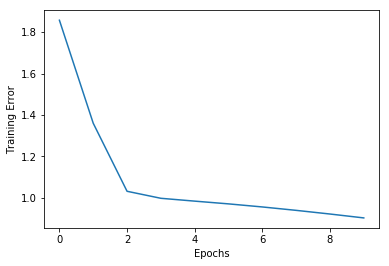

In [18]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

if os.path.exists('RecommenderV2.h5'):
    model = load_model('RecommenderV2.h5')
else:
    history = model.fit(x=X_train_array, y=y_train,  batch_size=10000, epochs=10,verbose=1, validation_data=(X_test_array, y_test))
    model.save('RecommenderV2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [19]:
from sklearn.metrics import mean_squared_error

prediction_test = np.array([a[0] for a in model.predict(x=X_test_array)])

print (mean_squared_error(y_test, prediction_test))

0.9935829194040907


## Neural network

In [20]:
from keras.layers import Concatenate, Dense, Dropout

def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        500000      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        50000       input_10[0][0]                   
____________________________________________________________________________________________

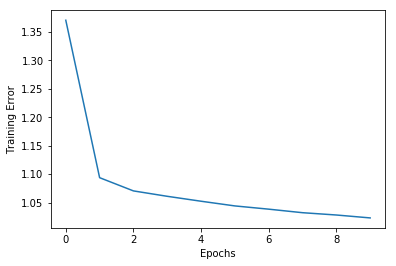

In [22]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

if os.path.exists('RecommenderNet.h5'):
    model = load_model('RecommenderNet.h5')
else:
    history = model.fit(x=X_train_array, y=y_train,  batch_size=10000, epochs=10,verbose=1, validation_data=(X_test_array, y_test))
    model.save('RecommenderNet.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [23]:
from sklearn.metrics import mean_squared_error

prediction_test = np.array([a[0] for a in model.predict(x=X_test_array)])

print (mean_squared_error(y_test, prediction_test))

1.002910094110525


## 2. Creating a dot product model

In [31]:
# Creating movie embedding path
movie_input = Input(shape=[1], name="Movies-Input")
movie_embedding = Embedding(n_movies+1, 5, name="Movies-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# Creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile(loss = 'mse', optimizer = 'adam')

In [32]:
from keras.models import load_model

if os.path.exists('regression_model_dot_product.h5'):
    model = load_model('regression_model_dot_product.h5')
else:
    history = model.fit([train.user_id, train.movie_id], train.rating, epochs=5,batch_size=64 ,verbose=1)
    model.save('regression_model_dot_product.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [33]:
scores = model.evaluate([test.user_id, test.movie_id], test.rating)


print("Accuracy: %.2f%%" % (scores*100))

predictions_dot= model.predict([submission.user_id, submission.movie_id])

117696/117696 [==============================] - 2s 13us/step
Accuracy: 100.92%


In [35]:
prediction_test = np.array([a[0] for a in model.predict([test.user_id, test.movie_id])])
prediction_test = np.floor(prediction_test)

prediction_test = np.where(prediction_test < 0, 0, prediction_test)
prediction_test = np.where(prediction_test > 5, 5, prediction_test)

Y = np.mean(np.where(prediction_test == test.rating, 1, 0))
print (Y)

[0 1 0 ... 0 0 0]
0.28967849374660143


,user_id,movie_id,rating
904556,7906,412,4
171326,1513,590,4
190893,1697,25,3
1082109,9264,833,1
881877,7730,403,3


In [7]:
predictions_dot = np.array([a[0] for a in predictions_dot])
prediction_dot = np.rint(predictions_dot)

prediction_dot = np.where(prediction_dot < 0, 0, prediction_dot)
prediction_dot = np.where(prediction_dot > 5, 5, prediction_dot)



submission.drop('rating',axis = 1, inplace = True)
submission['rating'] = prediction_dot

In [8]:
from helpers import load_csv
export_csv = load_csv('data/prediction_dot_product',submission)